# Informe Minería de Datos
## Grupo 18: Astrofísica
## Datos Astronómicos SDSS DR 10

### Introducción

En astronomía, el desarrollo tecnológico y de las ciencias computacionales ha permitido que el volumen de datos a estudiar crezca exponencialmente y cada vez más con los nuevos telescopios que se están construyendo e inaugurando al día de hoy y los grandes avanzes que esta dando el campo de estudio de datos, y por eso mismo la minería de datos se ha convertido en una herramienta indispensable para el análisis de datos astronómicos. 

En esta ocasión el estudio de fuentes requiere que identifiquemos cuáles objetos en el cielo están más cerca, estrellas, galaxias, y también considerar variables asociadadas, como lo es el redshift. Podemos distinguir entre ellos también a los agujeros negros supermasivos, que son hospedados en las AGN's (Active Galactic Nuclei), y que son los objetos más brillantes del universo. Dentro de ellos podemos encontrar a los objetos quasi-estelares (los denominados QSOs), los cuales son los principales objetos de estudio del cátalogo escogido.

Por otro lado, el uso de espectroscopía puede ser usada para medir redshifts de los diferentes objetos cósmicos, y poder diferenciar entre los diferentes tipos de fuentes, sin embargo la mayoría surveys deben caracterizar los objetos solamente basándose en la medición de imágenes.

Este proyecto se basará en el trabajo hecho en el paper de investigación Brescia et. al 2015, con diferencias principalmente en el área experimental, el cual propuso una red neuronal capaz de distinguir estos objetos galacticos mediante sus frecuencias y magnitudes observadas. De aqui surge nuestra pregunta de investigacion:

¿Podemos  predecir el redshift y clasificar objetos quasi-estelares, estelares, y galácticos usando fotometría, y seremos capazes de obtener resultados similares a los ya obtenidos con datos mas recientes y metodos mas simples?



### Exploración de Datos

***Los datos usados para este proyecto es el SDSS DR 10 (link: https://cdsarc.cds.unistra.fr/viz-bin/cat/J/MNRAS/450/3893#/browse), el cual posee más de 3 millones de espectros públicos con información relevante (ver anexo). Sin embargo, esta es una cantidad exagerada de datos, por lo que es obligatorio hacer una exploración y filtro de los datos para lograr definir un dataset que sea manejable y que nos permita realizar el análisis de forma eficiente (sobre todo limitados por la capacidad de computadores normales).***

Cada dato tiene 17 características, la primera "$objID$" representa el identificador único de cada objeto en la base de datos; '$Ra$' y '$Dec$' son las latitudes y longitudes en grados; "psfMaf_" de: "$u$", "$g$", "$r$", "$i$" y "$z$" representan las magnitudes PSF en su respectiva banda; '$u'$', '$g'$', '$r'$', '$i'$' y '$z'$' son las magnitudes con un mejor ajuste $DeV/Exp$ (exposición de la imagen), '$specID$' es el 'ID' en el catálogo de GAIA, '$subclass$' es la clasificación verificada de cada dato, '$z$' corresponde al redshift y '$Qf$' un medidor de la calidad y confiabilidad de los datos.

Antes empezar a trabajar hace falta filtrar los datos, primero buscamos que la mayoría de los datos tengan un redshift menor a 3, y que la distribución no sea homogénea, ademas que los datos tengan una subclase valida. Tras hacer esto quedamos con un total de 500.000 datos, los cuales se distribuyen como 315.305 galaxias, 148.513 estrellas y 36.182 QSO's. 

Ademas tenemos que normalizar con respecto a las diferencias de magnitudes, que son los datos que queremos usar para entrenar nuestro modelo, para lograr esto se siguen las magnitudes usadas en el paper, donde se define lo siguiente:

(i) −0.25 ≤ u − g ≤+1.00;
(ii) −0.25 ≤ g − r ≤+0.75;
(iii) +0.30 ≤ r − i ≤+0.50;
(iv) −0.30 ≤ i − z ≤+0.50.

Finalmente obtenemos nuestos datos X e Y, donde X son las diferencias de magnitudes (u-g,g-r,r-i,i-z) y Y son las subclases de cada dato (galaxia, estrella, QSO).

In [4]:
import pandas as pd
import numpy as np
# Carga
df = pd.read_csv("specphoto_dr19_500k_STAR_GAL_QSO.csv")

# Colores fotométricos a partir de psfMag
df["u_g"] = df["psfMag_u"] - df["psfMag_g"]
df["g_r"] = df["psfMag_g"] - df["psfMag_r"]
df["r_i"] = df["psfMag_r"] - df["psfMag_i"]
df["i_z"] = df["psfMag_i"] - df["psfMag_z"]

features_colors = ["u_g","g_r","r_i","i_z"]
target = "class"

# Conjunto limpio para clasificación
dft = df.dropna(subset = features_colors + [target]).copy()

print("Distribución de clases (dataset limpio):")
print(dft[target].value_counts())
dft.head()


Distribución de clases (dataset limpio):
class
GALAXY    315305
STAR      148513
QSO        36182
Name: count, dtype: int64


,objID,ra,dec,class,subClass,z,zErr,zWarning,specObjID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,u_g,g_r,r_i,i_z
0,1237663275781259455,2.284565,-1.170500,GALAXY,NaN,0.127346,0.000034,0,4.368717e+17,21.31720,19.60315,18.65152,18.23658,17.84867,1.71405,0.95163,0.41494,0.38791
1,1237663275781193883,2.121317,-1.104066,GALAXY,NaN,0.146719,0.000037,0,4.368728e+17,21.38685,19.59114,18.48957,18.07250,17.76950,1.79571,1.10157,0.41707,0.30300
2,1237657189832392792,2.086236,-0.974143,GALAXY,NaN,0.101256,0.000029,0,4.368731e+17,20.94495,19.10601,18.24100,17.84706,17.42474,1.83894,0.86501,0.39394,0.42232
3,1237663275781193897,2.144586,-1.131623,GALAXY,NaN,0.156883,0.000043,0,4.368734e+17,21.34352,19.91590,18.80721,18.30931,17.98475,1.42762,1.10869,0.49790,0.32456
4,1237663275781259407,2.197332,-1.083167,GALAXY,NaN,0.155292,0.000039,0,4.368737e+17,21.86584,19.80510,18.62355,18.22154,17.84274,2.06074,1.18155,0.40201,0.37880


In [25]:
#Agregamos las columna de diferencia de magnitudes y las normalizamos
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_all = dft[features_colors].values.astype(np.float64)
y_all = dft[target].values

scaler_pca = StandardScaler()
X_all_scaled = scaler_pca.fit_transform(X_all)

pca = PCA(n_components = 4, random_state = 42)
Z = pca.fit_transform(X_all_scaled)

print("Explained variance ratio:", np.round(pca.explained_variance_ratio_, 3))

loadings = pd.DataFrame(
    pca.components_,
    columns = features_colors,
    index = [f"PC{i + 1}" for i in range(4)]
)
loadings


Explained variance ratio: [0.448 0.302 0.17  0.079]


,u_g,g_r,r_i,i_z
PC1,-0.535576,0.144098,0.547921,-0.626240
PC2,-0.023182,-0.854275,0.465378,0.230434
PC3,0.844159,0.065599,0.357562,-0.394007
PC4,0.004031,0.495122,0.596117,0.632046


### Propuesta experimental

En el paper se utiliza el método Multi Layer Perceptron with Quasi Newton Algorith (MLPQNA) para la creación de la red neuronal, y se utiliza un dataset de alrededor de ~ 500K de datos. En nuestro caso, proponemos, de manera preliminar, la inyección de datos y actualización de datos del catálogo, ya que dimos cuenta de que el dataset referenciado según el autor, no es el mismo que el que se utiliza en el paper, en donde hay muchas más galaxias y estrellas presentes con ya confirmada su respectiva clasificación. 

El dataset que obtuvimos fue uno que contenía en su mayor parte QSO's. Por lo mismo, se propone una inyección de datos a través de queries en el catálogo, para poder obtener más datos de estrellas y galaxias, y así poder equilibrar el dataset, y si es posible y mejor aún, actualizar los datos, ya que actualmente el catálogo está en su versión DR19. 

A partir de ese dataset nuevo, se propone la creación de una red neuronal con la misma estructura que la utilizada en el paper, y se comparará los resultados obtenidos con los obtenidos en el paper. También se probarán métodos alternativos y más simples de clasificación, como por ejemplo, Random Forest. Por otra parte, se propone también la modificación de la estructura de la red neuronal, cambiando la cantidad de capas y neuronas por capa, o cambiando la función de activación de las capas ocultas, entre otras variaciones y ver la respuesta del modelo. Por el momento lo que se intentó fue reducir en base a un estándar de calidad astronómico (el parámetro concreto es $Qf$: Quality Flag) que poseen los mismos datos, lo que nos redujo a aproximadamente 74K objetos. Por otra parte, también consideraremos otras técnicas alternativas, como lo es el over o under-sampling, que es otra manera de balancear el dataset más allá de simplemente inyectarle más datos.

### Experimento Preliminar
**Importante:** Para el Hito 1 no es necesario que nosotros presentemos un resultado preliminar.

### Anexos
Gráficos y códigos complementarios con comentarios adicionales.

In [10]:
import gzip
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

# Definiendo las columnas pues los datos no las traen
columnas = ["objID", "RAdeg", "Dedeg", 
            "umag", "gmag", "rmag", "imag", "zmag", 
            "u'mag", "g'mag", "r'mag", "i'mag", "z'mag",
            "specID", "subclass", "z", "Qf"]

with gzip.open("dame_qso.dat.gz", "rt") as f:
    df = pd.read_csv(f, delim_whitespace=True, names=columnas, comment='#')
df.head()

,objID,RAdeg,Dedeg,umag,gmag,rmag,imag,zmag,u'mag,g'mag,r'mag,i'mag,z'mag,specID,subclass,z,Qf
0,1237669697834516732,332.193566,6.213506,20.694180,20.070652,19.902487,19.833360,19.617641,20.702007,20.066208,19.903557,19.825838,19.612368,2615518058759874560,BROADLINE,0.000461,0.0
1,1237668331500929566,242.615071,9.127335,20.184590,20.125793,20.083216,20.264364,19.954805,20.170850,20.102804,20.053980,20.253532,20.000866,2844050179592579072,BROADLINE,0.000461,1.0
2,1237678859536302437,338.916923,11.483463,21.678028,21.292742,21.197329,21.170238,21.538815,21.655334,21.272352,21.143225,21.130280,21.298502,5684755593458876416,4.6062307E-4,0.000000,NaN
3,1237667730193581111,120.828351,9.728672,22.114391,21.625710,21.480595,21.595968,21.215242,22.183746,21.623096,21.470402,21.597070,21.242352,6185898695620820992,5.767762E-4,0.000000,NaN
4,1237654626786738691,116.210005,31.646465,21.893473,21.455797,21.365667,21.404415,21.234035,21.910515,21.379683,21.280743,21.330507,21.222286,5002396468775485440,5.7690655E-4,0.000000,NaN


In [16]:
# Filtros

print("Datos inicialmente: " + str(df.shape))
# Nos aseguramos que es una subclase válida y que la calidad sea alta

subclases = ["BROADLINE","STARBURST" ,"STARBURST_BROADLINE" , "STARFORMING", "STARFORMING_BROADLINE", "AGN", "AGN_BROADLINE"]
df_raw = df.copy()
df = df[df["subclass"].isin(subclases) & df["Qf"] == 1]
print("Cantidad de datos luego de filtrar: " + str(df.shape))

Datos inicialmente: (500000, 18)


KeyError: 'subclass'

In [3]:
df

,objID,RAdeg,Dedeg,umag,gmag,rmag,imag,zmag,u'mag,g'mag,r'mag,i'mag,z'mag,specID,subclass,z,Qf
1,1237668331500929566,242.615071,9.127335,20.184590,20.125793,20.083216,20.264364,19.954805,20.170850,20.102804,20.053980,20.253532,20.000866,2844050179592579072,BROADLINE,0.000461,1.0
7,1237662225678532633,186.319981,40.446675,18.795190,18.477325,18.345972,18.348097,18.412870,18.807035,18.455065,18.341026,18.331991,18.414680,2236178285656565760,BROADLINE,0.001262,1.0
20,1237664669504438545,143.178401,32.767269,21.124222,20.793852,20.718037,20.740658,20.633980,21.126995,20.776814,20.682590,20.715467,20.639654,3329384236594601984,BROADLINE,0.006886,1.0
47,1237665566084890924,248.239594,11.844490,18.422323,18.244995,18.030874,17.668896,17.326725,17.339363,16.447384,15.842165,15.448892,15.133208,2852023837967542272,STARBURST_BROADLINE,0.046371,1.0
56,1237670964847378558,137.259814,13.505396,18.474594,18.052970,17.658827,17.219517,17.067451,17.101252,15.910120,15.184343,14.769672,14.467154,2740454731095762944,BROADLINE,0.049916,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190143,1237667229830283459,25.729317,7.999923,21.335537,20.897738,20.718325,20.609335,20.166210,21.333195,20.869867,20.706121,20.584856,20.208597,5121856208395304960,BROADLINE,3.789367,1.0
192228,1237657630051533048,137.477048,42.022296,20.269350,20.034216,19.475084,19.012148,18.832205,20.236849,19.996153,19.426977,18.967650,18.772293,1351203902908819456,BROADLINE,4.328177,1.0
192466,1237662498389426286,223.701400,44.154111,19.620745,19.183939,18.993090,18.813131,18.802258,19.598711,19.164886,18.967442,18.797894,18.795427,6807444376475140096,BROADLINE,4.934791,1.0
192532,1237650805884321887,165.579779,-1.428473,20.397434,20.004590,20.023746,19.789682,19.748840,20.405027,20.010628,20.028349,19.806660,19.754639,4318996661822554112,BROADLINE,5.397231,1.0


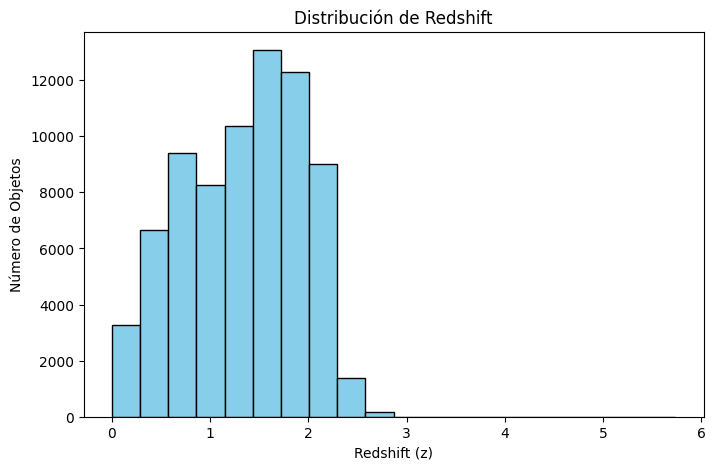

In [4]:
import matplotlib.pyplot as plt

# Veamos la distribución de redshift de nuestros datos

z = df["z"]
plt.figure(figsize = (8,5))
plt.hist(z, bins = 20, color = 'skyblue', edgecolor = 'black')
plt.xlabel("Redshift (z)")
plt.ylabel("Número de Objetos")
plt.title("Distribución de Redshift")
plt.show()

In [5]:
import numpy as np

# Clasificación general en QSO vs GAL
def coarse_qso_binary(sc):
    if pd.isna(sc):
        return np.nan
    s = str(sc).upper()
    # QSO si tiene BROADLINE
    if "BROADLINE" in s:
        return "QSO"
    # El resto que no es NaN lo tratamos como GALAXY
    return "GALAXY"

df["label_bin"] = df["subclass"].apply(coarse_qso_binary)
df_raw["label_bin"] = df_raw["subclass"].apply(coarse_qso_binary)

print(df["label_bin"].value_counts(dropna=False))


label_bin
QSO       73809
GALAXY       66
Name: count, dtype: int64


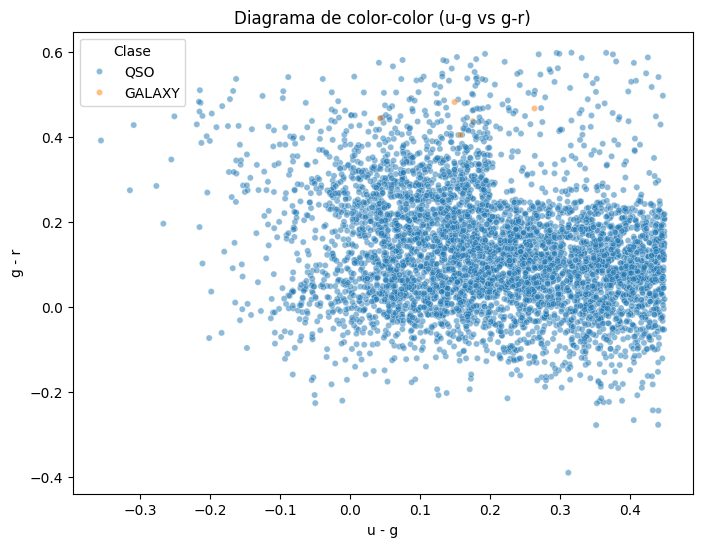

In [6]:
import seaborn as sns

# Vemos la distribución de subclases (QSO & GAL)

# Colores ugriz
for a,b in [("umag","gmag"),("gmag","rmag"),("rmag","imag"),("imag","zmag")]:
    df[f"{a[0]}-{b[0]}"] = df[a] - df[b]
    df_raw[f"{a[0]}-{b[0]}"] = df_raw[a] - df_raw[b]

# Tomamos un subconjunto
df_plot = df.sample(5000, random_state = 42)
df_rawplot = df_raw.sample(5000, random_state = 42)

#(u-g) vs (g-r)
plt.figure(figsize = (8,6))
sns.scatterplot(
    data = df_plot,
    x = "u-g", y = "g-r",
    hue = "label_bin",
    alpha = 0.5, s = 20, palette = {"QSO":"tab:blue", "GALAXY":"tab:orange"}
)
plt.xlabel("u - g")
plt.ylabel("g - r")
plt.title("Diagrama de color-color (u-g vs g-r)")
plt.legend(title="Clase")
plt.show()

Vemos claramente el desbalanceo de clases y también el cómo actúa el filtro de calidad Qf en ese rectángulo que se observa en la esquina superior derecha.

In [7]:
df["subclass"].value_counts()

subclass
BROADLINE                71002
STARBURST_BROADLINE       2675
STARFORMING_BROADLINE       88
AGN_BROADLINE               44
STARBURST                   36
AGN                         20
STARFORMING                 10
Name: count, dtype: int64

Representación numérico-cuantificable del desbalanceo. Los QSO's son las tres primeras categorías (BROADLINE), y las galaxias corresponden a las últimas 3.


Reporte de clasificación (binario QSO vs GALAXY)
              precision    recall  f1-score   support

      GALAXY      0.000     0.000     0.000        13
         QSO      0.999     1.000     1.000     14762

    accuracy                          0.999     14775
   macro avg      0.500     0.500     0.500     14775
weighted avg      0.998     0.999     0.999     14775



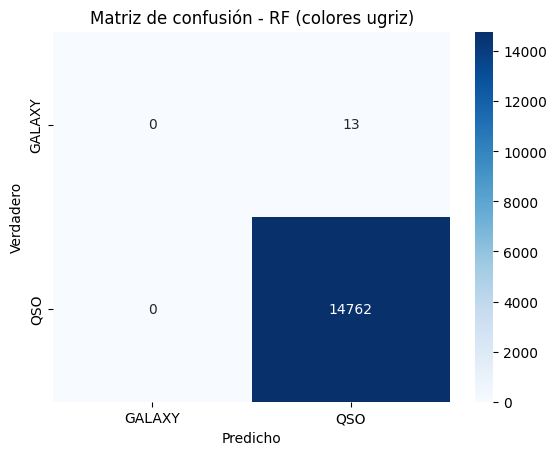

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

X = df[["u-g","g-r","r-i","i-z"]].values
y = df["label_bin"].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = 42
)

rf = RandomForestClassifier(
    n_estimators = 300,
    class_weight = "balanced",   # buscamos mitigar el desbalance entre QSO y GALAXY
    random_state = 42,
    n_jobs = -1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
print("\nReporte de clasificación (binario QSO vs GALAXY)")
print(classification_report(y_val, y_pred, digits = 3, zero_division = 0))

cm = confusion_matrix(y_val, y_pred, labels = ["GALAXY","QSO"])
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = ["GALAXY","QSO"], yticklabels = ["GALAXY","QSO"])
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de confusión - RF (colores ugriz)")
plt.show()

Como es posible apreciar, el desbalanceo es demasiado

Este es la red neuronal preeliminar, falta inyectar datos o hacer un mejor balanceo de clases, además de explorar el efecto y alcance de los parámetros.

Naive Bayes:

Cargando datos...
Datos cargados: 500000 filas, 14 columnas

Usando 10 columnas numéricas para entrenar:
['ra', 'dec', 'z', 'zErr', 'zWarning', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z']

Entrenando modelo Naive Bayes...
Evaluando modelo...

Matriz de confusión:
[[62714   261    86]
 [ 1702  5534     0]
 [   73    35 29595]]

Reporte de clasificación:
              precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98     63061
         QSO       0.95      0.76      0.85      7236
        STAR       1.00      1.00      1.00     29703

    accuracy                           0.98    100000
   macro avg       0.97      0.92      0.94    100000
weighted avg       0.98      0.98      0.98    100000



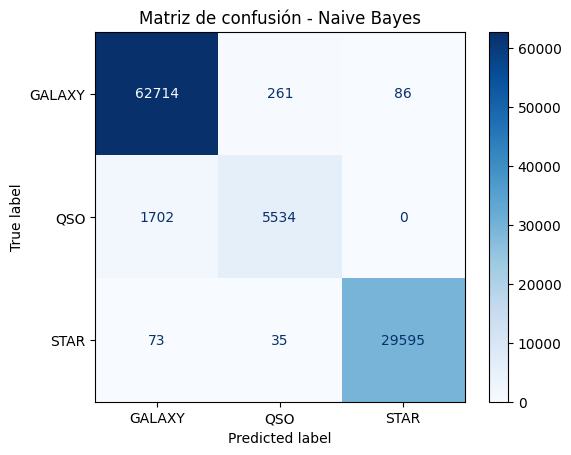

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===============================
# 1. CARGA DE DATOS
# ===============================
DATA_PATH = "specphoto_dr19_500k_STAR_GAL_QSO.csv" 

print("Cargando datos...")
df = pd.read_csv(DATA_PATH, low_memory=False)
print(f"Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas\n")

# ===============================
# 2. LIMPIEZA Y SELECCIÓN DE VARIABLES
# ===============================
# Variable objetivo
target_col = "class"

# Eliminar filas sin etiqueta
df = df.dropna(subset=[target_col])

# Eliminar columnas no útiles o puramente identificadoras
cols_to_drop = ["objID", "specObjID", "subClass"] 
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Filtrar solo columnas numéricas (Naive Bayes no acepta strings)
num_cols = df.select_dtypes(include=[np.number]).columns
X = df[num_cols]
y = df[target_col]

print(f"Usando {len(num_cols)} columnas numéricas para entrenar:\n{list(num_cols)}\n")

# ===============================
# 3. TRATAMIENTO DE NULOS
# ===============================
# Rellenar NaN con la media de cada columna (estrategia segura)
X = X.fillna(X.mean())

# ===============================
# 4. DIVISIÓN TRAIN/TEST
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===============================
# 5. ESCALADO DE VARIABLES
# ===============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===============================
# 6. ENTRENAMIENTO DEL MODELO
# ===============================
print("Entrenando modelo Naive Bayes...")
model = GaussianNB()
model.fit(X_train_scaled, y_train)

# ===============================
# 7. PREDICCIÓN Y EVALUACIÓN
# ===============================
print("Evaluando modelo...")
y_pred = model.predict(X_test_scaled)

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
print("\nMatriz de confusión:")
print(cm)

# --- Reporte de clasificación ---
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# --- Visualización ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title("Matriz de confusión - Naive Bayes")
plt.show()


In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("specphoto_dr19_500k_STAR_GAL_QSO.csv")

df["u_g"] = df["psfMag_u"] - df["psfMag_g"]
df["g_r"] = df["psfMag_g"] - df["psfMag_r"]
df["r_i"] = df["psfMag_r"] - df["psfMag_i"]
df["i_z"] = df["psfMag_i"] - df["psfMag_z"]

features_colors = ["u_g","g_r","r_i","i_z"]
target = "class"

# Limpieza mínima
dft = df.dropna(subset=features_colors + [target]).copy()

print("Distribución original:")
print(dft[target].value_counts())


Distribución original:
class
GALAXY    315305
STAR      148513
QSO        36182
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = dft[features_colors].values.astype(np.float64)
y = dft[target].values

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = 42
)

scaler = StandardScaler()
X_trs = scaler.fit_transform(X_tr)
X_tes = scaler.transform(X_te)

mlp_base = MLPClassifier(
    hidden_layer_sizes = (64,32),
    activation = "relu",
    solver = "adam",
    learning_rate_init = 1e-3,
    alpha = 1e-4,
    max_iter = 300,
    early_stopping = False,
    random_state = 42
)
mlp_base.fit(X_trs, y_tr)

y_pred_base = mlp_base.predict(X_tes)
print("BASELINE (sin re-muestreo)")
print(classification_report(y_te, y_pred_base, digits = 3))


In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

def eval_with_resampling(resampler, name):
    X_tr_res, y_tr_res = resampler.fit_resample(X_tr, y_tr)
    scaler_r = StandardScaler()
    X_trs_res = scaler_r.fit_transform(X_tr_res)
    X_tes_res = scaler_r.transform(X_te)

    clf = MLPClassifier(
        hidden_layer_sizes = (64,32),
        activation = "relu",
        solver = "adam",
        learning_rate_init = 1e-3,
        alpha = 1e-4,
        max_iter = 300,
        early_stopping = False,
        random_state = 42
    )
    clf.fit(X_trs_res, y_tr_res)
    y_pred = clf.predict(X_tes_res)
    print(f"\n=== {name} ===")
    print(classification_report(y_te, y_pred, digits = 3))
    return clf, scaler_r, y_pred

# Oversampling (duplica clases minoritarias)
ros = RandomOverSampler(random_state = 42)
clf_over, scaler_over, y_pred_over = eval_with_resampling(ros, "OVERSAMPLING (RandomOverSampler)")

# Undersampling (recorta la mayoritaria)
rus = RandomUnderSampler(random_state = 42)
clf_under, scaler_under, y_pred_under = eval_with_resampling(rus, "UNDERSAMPLING (RandomUnderSampler)")

# SMOTE
sm = SMOTE(random_state = 42, k_neighbors = 5)
clf_smote, scaler_smote, y_pred_smote = eval_with_resampling(sm, "OVERSAMPLING (SMOTE)")


In [ ]:
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, title):
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels = labels)
    plt.figure(figsize = (5,4.5))
    plt.imshow(cm, cmap = "Blues")
    plt.title(title)
    plt.xticks(range(len(labels)), labels, rotation = 45)
    plt.yticks(range(len(labels)), labels)
    for (i,j),v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha = "center", va = "center")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

plot_cm(y_te, y_pred_base, "CM — Baseline")
plot_cm(y_te, y_pred_over, "CM — Oversampling")
plot_cm(y_te, y_pred_under, "CM — Undersampling")
plot_cm(y_te, y_pred_smote, "CM — SMOTE")


In [ ]:
from sklearn.decomposition import PCA

# Aquí uso el del baseline:
X_all_scaled = scaler.transform(dft[features_colors].values.astype(np.float64))
y_all = dft[target].values

pca = PCA(n_components = 4, random_state = 42)
Z = pca.fit_transform(X_all_scaled)

print("Explained variance ratio:", np.round(pca.explained_variance_ratio_, 3))
print("Loadings (componentes):")
loadings = pd.DataFrame(pca.components_, columns=features_colors, index=[f"PC{i + 1}" for i in range(4)])
display(loadings)

In [ ]:
# submuestreamos para graficar más liviano
idx = np.random.RandomState(42).choice(len(Z), size = min(20000, len(Z)), replace = False)
Zs = Z[idx]; ys = y_all[idx]

plt.figure(figsize = (7,6))
for cls, col in zip(["STAR","GALAXY","QSO"], ["goldenrod","royalblue","crimson"]):
    mask = (ys == cls)
    plt.scatter(Zs[mask,0], Zs[mask,1], s = 6, alpha = 0.5, label = cls, color = col)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA en colores (u-g, g-r, r-i, i-z)")
plt.legend(markerscale = 2)
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9e84d318-4087-4f41-9461-781b450f49fb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>